In [1]:
import os
import csv
import re
import pickle
import random
import math
import dicom
import numpy as np
from tqdm import tqdm
from natsort import natsorted
from skimage import transform
from sklearn.externals import joblib
from scipy import ndimage
from matplotlib import path

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_filepaths():
    with open('../../data_supp/filepaths_train.pkl', 'rb') as f:
        filepaths_train = pickle.load(f)
    with open('../../data_supp/filepaths_val.pkl', 'rb') as f:
        filepaths_val = pickle.load(f)
    return filepaths_train, filepaths_val

In [3]:
def get_training_labels():
    systole_labels = {}
    diastole_labels = {}
    with open('../../data/train.csv', 'r') as f:
        for _id, systole, diastole in csv.reader(f):
            if _id == 'Id':
                continue
            systole_labels[int(_id)] = float(systole)
            diastole_labels[int(_id)] = float(diastole)
    return systole_labels, diastole_labels

In [4]:
systole_labels, diastole_labels = get_training_labels()

# return tuple of real value and function represetation
def create_label(pt, mode='ED'):
    if mode == 'ES':
        return systole_labels[pt], systole_labels[pt] < np.arange(600)
    elif mode == 'ED':
        return diastole_labels[pt], diastole_labels[pt] < np.arange(600)
    else:
        raise

In [5]:
def apply_window(arr, window_center, window_width):
    return np.clip(arr, window_center - window_width/2, window_center + window_width/2)

In [6]:
def apply_per_slice_norm(arr):
    mean = np.mean(arr.ravel())
    std = np.std(arr.ravel())
    if std == 0:
        return np.zeros(arr.shape)
    return (arr - mean) / std

In [7]:
def crop_to_square(arr, size):
    x_len, y_len = arr.shape
    shorter_len = min(x_len, y_len)
    x_start = (arr.shape[0] - shorter_len) // 2
    x_end = x_start + shorter_len
    y_start = (arr.shape[1] - shorter_len) // 2
    y_end = y_start + shorter_len
    return transform.resize(arr[x_start:x_end, y_start:y_end], 
                            (size, size), order=1, clip=True, preserve_range=True)

In [8]:
def interp_vol3d(vol3d, z_locs, nb_slices_z):
    
    def find_interval(test_loc):
        for i in range(len(z_locs) - 1):
            if z_locs[i] <= test_loc <= z_locs[i+1]:
                return i
        return 0
        
    # vol3d shape is (depth, row, col)
    # z_locs are the slice locations corresponding to slices along the depth axis
    # we reshape through interpolation to nb_slices_z along the depth axis
    vol3d_new = np.zeros((nb_slices_z, vol3d.shape[1], vol3d.shape[2]))
    z_locs_new = [z_locs[0]]
    for i in range(1, nb_slices_z - 1):
        z_locs_new.append(z_locs[0] + i * (z_locs[-1] - z_locs[0]) / (nb_slices_z - 1))
    z_locs_new.append(z_locs[-1])
    
    for z, loc in enumerate(z_locs_new):
        if z == 0:
            vol3d_new[0, :, :] = vol3d[0, :, :]
        elif z == len(z_locs_new) - 1:
            vol3d_new[-1, :, :] = vol3d[-1, :, :]
        else:
            idx = find_interval(loc)
            z_loc_lower = z_locs[idx]
            z_loc_upper = z_locs[idx + 1]
            vol3d_new[z, :, :] = vol3d[idx, :, :] + ((loc - z_loc_lower) / (z_loc_upper - z_loc_lower)) * (vol3d[idx+1, :, :] - vol3d[idx, :, :])
            
    return vol3d_new
    

In [9]:
def get_all_series_filepaths(filepaths):
    t_slices = 30
    
    # create sax series filepaths
    # handles irregularies such as those including z-slices and t-slices in the same folder
    series_filepaths_all = []
    for view in filepaths.keys(): 
        if not re.match(r'^sax', view):
            continue
        
        if len(filepaths[view]) == t_slices:
            series_filepaths_all.append(filepaths[view])
        elif len(filepaths[view]) < t_slices:
            series_filepaths_all.append(filepaths[view][:] + filepaths[view][:(t_slices - len(filepaths[view]))])
        else:
            if re.match(r'^\w+-\d+-\d+-\d+.dcm$', filepaths[view][0][0]) is not None:
                series_filepaths_split = []
                slices_list = []
                series_filepaths_sort_by_slice = sorted(filepaths[view][:], 
                                                        key=lambda x: '{}-{}'.format(x[0].split('-')[-1].split('.')[0], 
                                                                                     x[0].split('-')[-2]))
                for fname, fpath in series_filepaths_sort_by_slice:
                    nslice = fname.split('-')[-1].split('.')[0]
                    tframe = fname.split('-')[-2]
                    if nslice not in slices_list:
                        if len(series_filepaths_split) == t_slices:
                            series_filepaths_all.append(series_filepaths_split)
                        elif len(series_filepaths_split) < t_slices and len(series_filepaths_split) > 0:
                            series_filepaths_all.append((series_filepaths_split[:] + 
                                                         series_filepaths_split[:(t_slices - len(series_filepaths_split))]))
                        series_filepaths_split = []
                        series_filepaths_split.append((fname, fpath))
                        slices_list.append(nslice)
                    else:
                        series_filepaths_split.append((fname, fpath))
                        
    return series_filepaths_all

In [10]:
filepaths_train, filepaths_val = get_filepaths()

### ES frame detection classifier

In [11]:
es_frame_clf = joblib.load('../../model_weights/ES_detection_GBR.pkl')

# assumes images are already cropped / normalized
def pred_es_frame(image_stack_series, img_size=256):
    seqs = []
    for image_stack in image_stack_series:
        nb_frames = 30
        if len(image_stack) != nb_frames:
            image_stack += image_stack[-1] * (30 - len(image_stack))

        mean_diff_seq = []
        img_ED = image_stack[0]
        for img_frame in image_stack[1:]:
            differences = []
            img_percent_diff = (img_frame - img_ED) / (img_ED + 1e-6)
            differences.append(np.mean(img_percent_diff))
            differences.append(np.mean(np.abs(img_percent_diff)))

            for scaling in [2, 4, 8]:
                for i in range(scaling):
                    for j in range(scaling):
                        differences.append(np.mean(img_percent_diff[(i*img_size//scaling):((i+1)*img_size//scaling), 
                                                                    (i*img_size//scaling):((i+1)*img_size//scaling)], 
                                                   axis=None))
                        differences.append(np.mean(np.abs(img_percent_diff[(i*img_size//scaling):((i+1)*img_size//scaling), 
                                                                           (i*img_size//scaling):((i+1)*img_size//scaling)]), 
                                                   axis=None))

            mean_diff_seq.append(differences)

        seqs.append(np.array(mean_diff_seq).astype(np.float32))
        
    preds = es_frame_clf.predict([x.ravel() for x in seqs])
    es_frame_pred = np.clip(np.round(np.mean(preds)), 1, nb_frames - 1)
    return es_frame_pred

In [ ]:
pt_es_frame = {}

for pt in tqdm(filepaths_train.keys()):
    series_filepaths_all = get_all_series_filepaths(filepaths_train[pt])
    image_stack_series = []
    for series_filepaths in series_filepaths_all:
        image_stack = []
        for i, (fname, fpath) in enumerate(series_filepaths):
            image_stack.append(apply_per_slice_norm(crop_to_square(dicom.read_file(fpath).pixel_array, 256)))
        image_stack_series.append(image_stack)
    pt_es_frame[pt] = pred_es_frame(image_stack_series, img_size=256)
    
for pt in tqdm(filepaths_val.keys()):
    series_filepaths_all = get_all_series_filepaths(filepaths_val[pt])
    image_stack_series = []
    for series_filepaths in series_filepaths_all:
        image_stack = []
        for i, (fname, fpath) in enumerate(series_filepaths):
            image_stack.append(apply_per_slice_norm(crop_to_square(dicom.read_file(fpath).pixel_array, 256)))
        image_stack_series.append(image_stack)
    pt_es_frame[pt] = pred_es_frame(image_stack_series, img_size=256)

In [52]:
print(pt_es_frame[1])
print(pt_es_frame[501])

9.0
12.0


In [53]:
pt_es_frame = dict((k, int(v)) for k, v in pt_es_frame.items())

In [54]:
with open('../../data_supp/pt_es_frame.pkl', 'wb') as f:
    pickle.dump(pt_es_frame, f)

### LV segmentation net

In [11]:
from keras.models import Sequential, Graph
from keras.layers.core import Activation, Dense, Dropout, Flatten, Merge, Reshape, Lambda
from keras.layers.core import TimeDistributedDense, TimeDistributedMerge
from keras.layers.recurrent import LSTM, GRU
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, PReLU, ParametricSoftplus, ELU
from keras.layers.normalization import BatchNormalization
from keras.layers.noise import GaussianDropout, GaussianNoise
from keras.utils import np_utils, generic_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import initializations
from keras.layers.core import Layer
from keras import backend as K

# for preventing python max recursion limit error
import sys
sys.setrecursionlimit(50000)

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=None, keepdims=False))

def binaryCE(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_pred, y_true), axis=None, keepdims=False)

class Rotate90(Layer):
    def __init__(self, direction='clockwise', **kwargs):
        super(Rotate90, self).__init__(**kwargs)
        self.direction = direction

    def get_output(self, train):
        X = self.get_input(train)
        if self.direction == 'clockwise':
            return X.transpose((0, 2, 1))[:, :, ::-1]
        elif self.direction == 'counterclockwise':
            return X.transpose((0, 2, 1))[:, ::-1, :]
        else:
            raise

    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(Rotate90, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
LV_model = Graph()

LV_model.add_input(name='input', input_shape=(1, 256, 256))

LV_model.add_node(Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-1-1', input='input')
LV_model.add_node(BatchNormalization(), name='conv-1-1-bn', input='conv-1-1')
LV_model.add_node(ELU(), name='conv-1-1-activ', input='conv-1-1-bn')
LV_model.add_node(Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-1-2', input='conv-1-1-activ')
LV_model.add_node(BatchNormalization(), name='conv-1-2-bn', input='conv-1-2')
LV_model.add_node(ELU(), name='conv-1-2-activ', input='conv-1-2-bn')
LV_model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-1', input='conv-1-2-activ')

LV_model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-2-1', input='pool-1')
LV_model.add_node(BatchNormalization(), name='conv-2-1-bn', input='conv-2-1')
LV_model.add_node(ELU(), name='conv-2-1-activ', input='conv-2-1-bn')
LV_model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-2-2', input='conv-2-1-activ')
LV_model.add_node(BatchNormalization(), name='conv-2-2-bn', input='conv-2-2')
LV_model.add_node(ELU(), name='conv-2-2-activ', input='conv-2-2-bn')
LV_model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-2', input='conv-2-2-activ')

LV_model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-3-1', input='pool-2')
LV_model.add_node(BatchNormalization(), name='conv-3-1-bn', input='conv-3-1')
LV_model.add_node(ELU(), name='conv-3-1-activ', input='conv-3-1-bn')
LV_model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-3-2', input='conv-3-1-activ')
LV_model.add_node(BatchNormalization(), name='conv-3-2-bn', input='conv-3-2')
LV_model.add_node(ELU(), name='conv-3-2-activ', input='conv-3-2-bn')
LV_model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-3-3', input='conv-3-2-activ')
LV_model.add_node(BatchNormalization(), name='conv-3-3-bn', input='conv-3-3')
LV_model.add_node(ELU(), name='conv-3-3-activ', input='conv-3-3-bn')
LV_model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-3', input='conv-3-3-activ')

LV_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-4-1', input='pool-3')
LV_model.add_node(BatchNormalization(), name='conv-4-1-bn', input='conv-4-1')
LV_model.add_node(ELU(), name='conv-4-1-activ', input='conv-4-1-bn')
LV_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-4-2', input='conv-4-1-activ')
LV_model.add_node(BatchNormalization(), name='conv-4-2-bn', input='conv-4-2')
LV_model.add_node(ELU(), name='conv-4-2-activ', input='conv-4-2-bn')
LV_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-4-3', input='conv-4-2-activ')
LV_model.add_node(BatchNormalization(), name='conv-4-3-bn', input='conv-4-3')
LV_model.add_node(ELU(), name='conv-4-3-activ', input='conv-4-3-bn')
LV_model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-4', input='conv-4-3-activ')

LV_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-5-1', input='pool-4')
LV_model.add_node(BatchNormalization(), name='conv-5-1-bn', input='conv-5-1')
LV_model.add_node(ELU(), name='conv-5-1-activ', input='conv-5-1-bn')
LV_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-5-2', input='conv-5-1-activ')
LV_model.add_node(BatchNormalization(), name='conv-5-2-bn', input='conv-5-2')
LV_model.add_node(ELU(), name='conv-5-2-activ', input='conv-5-2-bn')
LV_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-5-3', input='conv-5-2-activ')
LV_model.add_node(BatchNormalization(), name='conv-5-3-bn', input='conv-5-3')
LV_model.add_node(ELU(), name='conv-5-3-activ', input='conv-5-3-bn')
LV_model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-5', input='conv-5-3-activ')

LV_model.add_node(Flatten(), name='flatten', input='pool-5')
LV_model.add_node(Dense(4096, activation='relu'), name='fc-1', input='flatten')
LV_model.add_node(Dropout(0.5), name='dropout-1', input='fc-1')
LV_model.add_node(Dense(4096, activation='relu'), name='fc-2', input='dropout-1')
LV_model.add_node(Dropout(0.5), name='dropout-2', input='fc-2')
LV_model.add_node(Reshape((64, 8, 8)), name='reshape', input='dropout-2')

LV_model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-1', input='reshape')
LV_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-1-1', input='unpool-1')
LV_model.add_node(BatchNormalization(), name='deconv-1-1-bn', input='deconv-1-1')
LV_model.add_node(ELU(), name='deconv-1-1-activ', input='deconv-1-1-bn')
LV_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-1-2', input='deconv-1-1-activ')
LV_model.add_node(BatchNormalization(), name='deconv-1-2-bn', input='deconv-1-2')
LV_model.add_node(ELU(), name='deconv-1-2-activ', input='deconv-1-2-bn')
LV_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-1-3', input='deconv-1-2-activ')
LV_model.add_node(BatchNormalization(), name='deconv-1-3-bn', input='deconv-1-3')
LV_model.add_node(ELU(), name='deconv-1-3-activ', input='deconv-1-3-bn')

LV_model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-2', input='deconv-1-3-activ')
LV_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-2-1', input='unpool-2')
LV_model.add_node(BatchNormalization(), name='deconv-2-1-bn', input='deconv-2-1')
LV_model.add_node(ELU(), name='deconv-2-1-activ', input='deconv-2-1-bn')
LV_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-2-2', input='deconv-2-1-activ')
LV_model.add_node(BatchNormalization(), name='deconv-2-2-bn', input='deconv-2-2')
LV_model.add_node(ELU(), name='deconv-2-2-activ', input='deconv-2-2-bn')
LV_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-2-3', input='deconv-2-2-activ')
LV_model.add_node(BatchNormalization(), name='deconv-2-3-bn', input='deconv-2-3')
LV_model.add_node(ELU(), name='deconv-2-3-activ', input='deconv-2-3-bn')

LV_model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-3', input='deconv-2-3-activ')
LV_model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-3-1', input='unpool-3')
LV_model.add_node(BatchNormalization(), name='deconv-3-1-bn', input='deconv-3-1')
LV_model.add_node(ELU(), name='deconv-3-1-activ', input='deconv-3-1-bn')
LV_model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-3-2', input='deconv-3-1-activ')
LV_model.add_node(BatchNormalization(), name='deconv-3-2-bn', input='deconv-3-2')
LV_model.add_node(ELU(), name='deconv-3-2-activ', input='deconv-3-2-bn')
LV_model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-3-3', input='deconv-3-2-activ')
LV_model.add_node(BatchNormalization(), name='deconv-3-3-bn', input='deconv-3-3')
LV_model.add_node(ELU(), name='deconv-3-3-activ', input='deconv-3-3-bn')

LV_model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-4', input='deconv-3-3-activ')
LV_model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-4-1', input='unpool-4')
LV_model.add_node(BatchNormalization(), name='deconv-4-1-bn', input='deconv-4-1')
LV_model.add_node(ELU(), name='deconv-4-1-activ', input='deconv-4-1-bn')
LV_model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-4-2', input='deconv-4-1-activ')
LV_model.add_node(BatchNormalization(), name='deconv-4-2-bn', input='deconv-4-2')
LV_model.add_node(ELU(), name='deconv-4-2-activ', input='deconv-4-2-bn')

LV_model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-5', input='deconv-4-2-activ')
LV_model.add_node(Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-5-1', input='unpool-5')
LV_model.add_node(BatchNormalization(), name='deconv-5-1-bn', input='deconv-5-1')
LV_model.add_node(ELU(), name='deconv-5-1-activ', input='deconv-5-1-bn')
LV_model.add_node(Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-5-2', input='deconv-5-1-activ')
LV_model.add_node(BatchNormalization(), name='deconv-5-2-bn', input='deconv-5-2')
LV_model.add_node(ELU(), name='deconv-5-2-activ', input='deconv-5-2-bn')

LV_model.add_node(Convolution2D(1, 1, 1, activation='sigmoid', init='uniform', border_mode='same', dim_ordering='th'),
               name='prob-map', input='deconv-5-2-activ')
LV_model.add_node(Reshape((256, 256)), name='prob-map-reshape', input='prob-map')
LV_model.add_node(Dropout(0.5), name='prob-map-dropout', input='prob-map-reshape')

LV_model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', return_sequences=True),
               name='rnn-we', input='prob-map-dropout')
LV_model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', go_backwards=True, return_sequences=True),
               name='rnn-ew', input='prob-map-dropout')
LV_model.add_node(TimeDistributedDense(256, init='uniform', activation='sigmoid'),
               name='rnn-1', inputs=['rnn-we', 'rnn-ew'], merge_mode='concat', concat_axis=-1)

LV_model.add_node(Rotate90(direction='counterclockwise'), name='rotate', input='prob-map-dropout')
LV_model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', return_sequences=True),
               name='rnn-ns', input='rotate')
LV_model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', go_backwards=True, return_sequences=True),
               name='rnn-sn', input='rotate')
LV_model.add_node(TimeDistributedDense(256, init='uniform', activation='sigmoid'),
               name='rnn-2-rotated', inputs=['rnn-ns', 'rnn-sn'], merge_mode='concat', concat_axis=-1)
LV_model.add_node(Rotate90(direction='clockwise'), name='rnn-2', input='rnn-2-rotated')

LV_model.add_node(Activation('linear'), name='pre-output', inputs=['rnn-1', 'rnn-2'], merge_mode='mul')
LV_model.add_output(name='output', input='pre-output')

LV_model.compile('adam', {'output': binaryCE})

LV_model.load_weights('../../model_weights/manual_001-100_plus_sunnybrook_segmentation.hdf5')

Using Theano backend.


Using gpu device 3: Tesla K80 (CNMeM is disabled)


In [12]:
def pred_segment_mask(image_stack):
    return LV_model.predict({'input': np.expand_dims(np.array(image_stack).astype(np.float32), axis=1)}, 
                            verbose=0)['output']

### preprocess data

In [13]:
with open('../../data_supp/pt_es_frame.pkl', 'rb') as f:
    pt_es_frame = pickle.load(f)

In [14]:
train_val_split = 0.05
pts_train_val = random.sample(list(range(1, 501)), int(500 * train_val_split))
pts_train = list(set(range(1, 501)) - set(pts_train_val))

In [21]:
def create_volumes_sax(filepaths, img_size=256, nb_slices_z=12, frame=0):
    series_filepaths_all = get_all_series_filepaths(filepaths)
                        
    # sort series by z-locations
    z_locs = []
    for series_filepaths in series_filepaths_all:
        df = dicom.read_file(series_filepaths[0][1])
        z_locs.append(df.SliceLocation)
    series_filepaths_all_zsorted = [series_filepaths for (loc, series_filepaths) in sorted(zip(z_locs, 
                                                                                               series_filepaths_all), 
                                                                                           key=lambda pair: pair[0])]
    z_locs = sorted(z_locs)
    
    # create 3d volumes
    vol3d = []
    for series_filepaths in series_filepaths_all_zsorted:
        fname, fpath = natsorted(series_filepaths, lambda x: x[0])[frame]
        img2d = apply_per_slice_norm(crop_to_square(dicom.read_file(fpath).pixel_array, img_size))
        vol3d.append(img2d.astype(np.float32))
    vol3d_mask = pred_segment_mask(vol3d)
    vol3d = interp_vol3d(np.array(vol3d).astype(np.float32), z_locs, nb_slices_z)
    vol3d = [np.expand_dims(vol3d[i].astype(np.float32), axis=0) for i in range(len(vol3d))]
    vol3d_mask = interp_vol3d(vol3d_mask, z_locs, nb_slices_z)
    vol3d_mask = [np.expand_dims(vol3d_mask[i,:,:].astype(np.float32), axis=0) for i in range(vol3d_mask.shape[0])]
        
    return vol3d, vol3d_mask

In [22]:
img_size = 256
nb_slices_z = 12

# training
data_ED_train = [[] for i in range(nb_slices_z * 2)]
data_ES_train = [[] for i in range(nb_slices_z * 2)]
labels_value_ED_train = []
labels_value_ES_train = []
labels_func_ED_train = []
labels_func_ES_train = []

# training local validation
data_ED_train_val = [[] for i in range(nb_slices_z * 2)]
data_ES_train_val = [[] for i in range(nb_slices_z * 2)]
labels_value_ED_train_val = []
labels_value_ES_train_val = []
labels_func_ED_train_val = []
labels_func_ES_train_val = []

# validation
data_ED_val = [[] for i in range(nb_slices_z * 2)]
data_ES_val = [[] for i in range(nb_slices_z * 2)]
data_val_pt_index = []

for pt in tqdm(filepaths_train.keys()):
    vol3d_ED, vol3d_mask_ED = create_volumes_sax(filepaths_train[pt], 
                                                 img_size=img_size, 
                                                 nb_slices_z=nb_slices_z,
                                                 frame=0)
    vol3d_ES, vol3d_mask_ES = create_volumes_sax(filepaths_train[pt], 
                                                 img_size=img_size, 
                                                 nb_slices_z=nb_slices_z,
                                                 frame=pt_es_frame[pt])
    assert(len(vol3d_ED) == len(vol3d_ES))
    assert(len(vol3d_ED) == len(vol3d_mask_ED))
    assert(len(vol3d_ED) == len(vol3d_mask_ES))
    
    label_value_ES, label_func_ES = create_label(pt, mode='ES')
    label_value_ED, label_func_ED = create_label(pt, mode='ED')
    
    if pt in pts_train:
        for i in range(len(vol3d_ED)):
            data_ED_train[2*i].append(vol3d_ED[i])
            data_ES_train[2*i].append(vol3d_ES[i])
            data_ED_train[2*i+1].append(vol3d_mask_ED[i])
            data_ES_train[2*i+1].append(vol3d_mask_ES[i])
        labels_value_ED_train.append(label_value_ED)
        labels_value_ES_train.append(label_value_ES)
        labels_func_ED_train.append(label_func_ED)
        labels_func_ES_train.append(label_func_ES)
    elif pt in pts_train_val:
        for i in range(len(vol3d_ED)):
            data_ED_train_val[2*i].append(vol3d_ED[i])
            data_ES_train_val[2*i].append(vol3d_ES[i])
            data_ED_train_val[2*i+1].append(vol3d_mask_ED[i])
            data_ES_train_val[2*i+1].append(vol3d_mask_ES[i])
        labels_value_ED_train_val.append(label_value_ED)
        labels_value_ES_train_val.append(label_value_ES)
        labels_func_ED_train_val.append(label_func_ED)
        labels_func_ES_train_val.append(label_func_ES)

        
for pt in tqdm(filepaths_val.keys()):
    vol3d_ED, vol3d_mask_ED = create_volumes_sax(filepaths_val[pt], 
                                                 img_size=img_size, 
                                                 nb_slices_z=nb_slices_z,
                                                 frame=0)
    vol3d_ES, vol3d_mask_ES = create_volumes_sax(filepaths_val[pt], 
                                                 img_size=img_size, 
                                                 nb_slices_z=nb_slices_z,
                                                 frame=pt_es_frame[pt])
    assert(len(vol3d_ED) == len(vol3d_ES))
    assert(len(vol3d_ED) == len(vol3d_mask_ED))
    assert(len(vol3d_ED) == len(vol3d_mask_ES))
        
    for i in range(len(vol3d_ED)):
        data_ED_val[2*i].append(vol3d_ED[i])
        data_ES_val[2*i].append(vol3d_ES[i])
        data_ED_val[2*i+1].append(vol3d_mask_ED[i])
        data_ES_val[2*i+1].append(vol3d_mask_ES[i])

    data_val_pt_index.append(int(pt))

for i in range(nb_slices_z * 2):
    data_ED_train[i] = np.array(data_ED_train[i]).astype(np.float32)
    data_ES_train[i] = np.array(data_ES_train[i]).astype(np.float32)
labels_value_ED_train = np.array(labels_value_ED_train).astype(np.float32)
labels_value_ES_train = np.array(labels_value_ES_train).astype(np.float32)
labels_func_ED_train = np.array(labels_func_ED_train).astype(np.bool)
labels_func_ES_train = np.array(labels_func_ES_train).astype(np.bool)
print(len(data_ED_train), len(data_ES_train), 
      data_ED_train[0].shape, data_ES_train[0].shape, 
      labels_value_ED_train.shape, labels_value_ES_train.shape,
      labels_func_ED_train.shape, labels_func_ES_train.shape)

for i in range(nb_slices_z * 2):
    data_ED_train_val[i] = np.array(data_ED_train_val[i]).astype(np.float32)
    data_ES_train_val[i] = np.array(data_ES_train_val[i]).astype(np.float32)
labels_value_ED_train_val = np.array(labels_value_ED_train_val).astype(np.float32)
labels_value_ES_train_val = np.array(labels_value_ES_train_val).astype(np.float32)
labels_func_ED_train_val = np.array(labels_func_ED_train_val).astype(np.bool)
labels_func_ES_train_val = np.array(labels_func_ES_train_val).astype(np.bool)
print(len(data_ED_train_val), len(data_ES_train_val), 
      data_ED_train_val[0].shape, data_ES_train_val[0].shape, 
      labels_value_ED_train_val.shape, labels_value_ES_train_val.shape,
      labels_func_ED_train_val.shape, labels_func_ES_train_val.shape)

for i in range(nb_slices_z * 2):
    data_ED_val[i] = np.array(data_ED_val[i]).astype(np.float32)
    data_ES_val[i] = np.array(data_ES_val[i]).astype(np.float32)
data_val_pt_index = np.array(data_val_pt_index).astype(np.uint16)
print(len(data_ED_val), len(data_ES_val), 
      data_ED_val[0].shape, data_ES_val[0].shape, 
      data_val_pt_index.shape)

24 24 (475, 1, 256, 256) (475, 1, 256, 256) (475,) (475,) (475, 600) (475, 600)
24 24 (25, 1, 256, 256) (25, 1, 256, 256) (25,) (25,) (25, 600) (25, 600)
24 24 (200, 1, 256, 256) (200, 1, 256, 256) (200,)


In [23]:
joblib.dump((pts_train, pts_train_val, 
             data_ED_train, data_ES_train, 
             labels_value_ED_train, labels_value_ES_train, labels_func_ED_train, labels_func_ES_train, 
             data_ED_train_val, data_ES_train_val, 
             labels_value_ED_train_val, labels_value_ES_train_val, labels_func_ED_train_val, labels_func_ES_train_val, 
             data_ED_val, data_ES_val, data_val_pt_index), 
            '../../data_proc/data_with_base_masks.pkl')

['../../data_proc/data_with_base_masks.pkl',
 '../../data_proc/data_with_base_masks.pkl_01.npy',
 '../../data_proc/data_with_base_masks.pkl_02.npy',
 '../../data_proc/data_with_base_masks.pkl_03.npy',
 '../../data_proc/data_with_base_masks.pkl_04.npy',
 '../../data_proc/data_with_base_masks.pkl_05.npy',
 '../../data_proc/data_with_base_masks.pkl_06.npy',
 '../../data_proc/data_with_base_masks.pkl_07.npy',
 '../../data_proc/data_with_base_masks.pkl_08.npy',
 '../../data_proc/data_with_base_masks.pkl_09.npy',
 '../../data_proc/data_with_base_masks.pkl_10.npy',
 '../../data_proc/data_with_base_masks.pkl_11.npy',
 '../../data_proc/data_with_base_masks.pkl_12.npy',
 '../../data_proc/data_with_base_masks.pkl_13.npy',
 '../../data_proc/data_with_base_masks.pkl_14.npy',
 '../../data_proc/data_with_base_masks.pkl_15.npy',
 '../../data_proc/data_with_base_masks.pkl_16.npy',
 '../../data_proc/data_with_base_masks.pkl_17.npy',
 '../../data_proc/data_with_base_masks.pkl_18.npy',
 '../../data_proc/d

### Plots

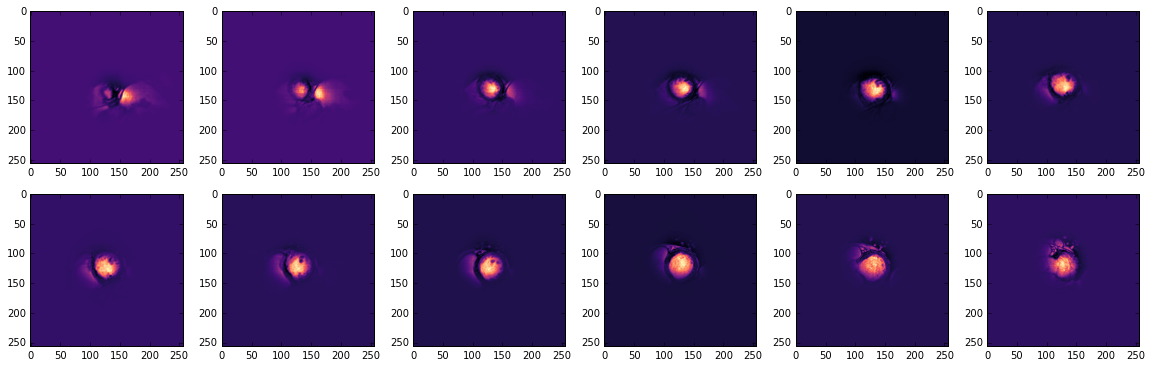

In [72]:
plt.figure(figsize=(20,6))    
for s in range(12):
    plt.subplot(2, 6, s+1)
    plt.imshow((data_ED_train[s*2][0] * data_ED_train[s*2+1][0])[0,:,:], cmap=plt.cm.magma)

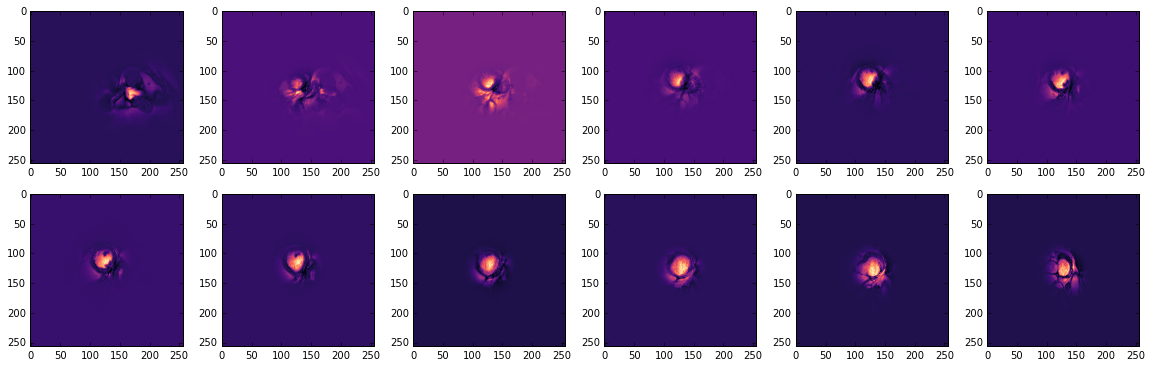

In [64]:
plt.figure(figsize=(20,6))    
for s in range(12):
    plt.subplot(2, 6, s+1)
    plt.imshow((data_ED_train[s*2][1] * data_ED_train[s*2+1][1])[0,:,:], cmap=plt.cm.magma)

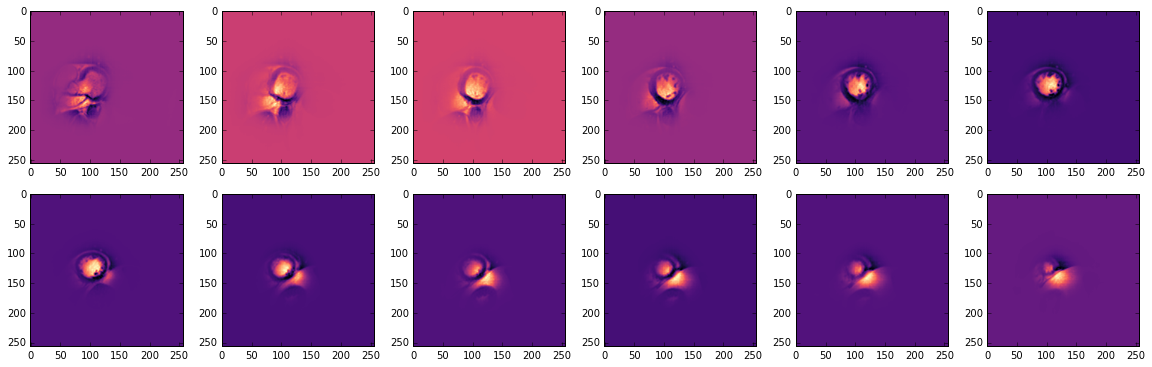

In [69]:
plt.figure(figsize=(20,6))    
for s in range(12):
    plt.subplot(2, 6, s+1)
    plt.imshow((data_ED_train[s*2][2] * data_ED_train[s*2+1][2])[0,:,:], cmap=plt.cm.magma)

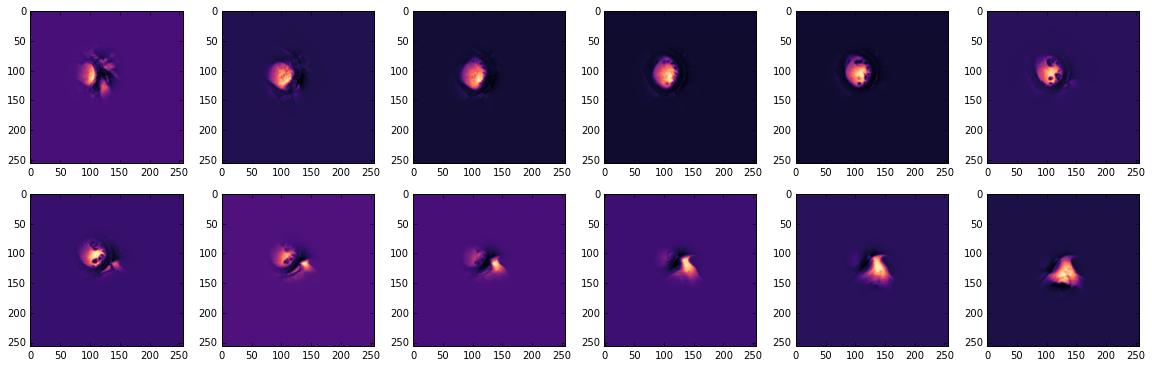

In [70]:
plt.figure(figsize=(20,6))    
for s in range(12):
    plt.subplot(2, 6, s+1)
    plt.imshow((data_ED_train[s*2][3] * data_ED_train[s*2+1][3])[0,:,:], cmap=plt.cm.magma)

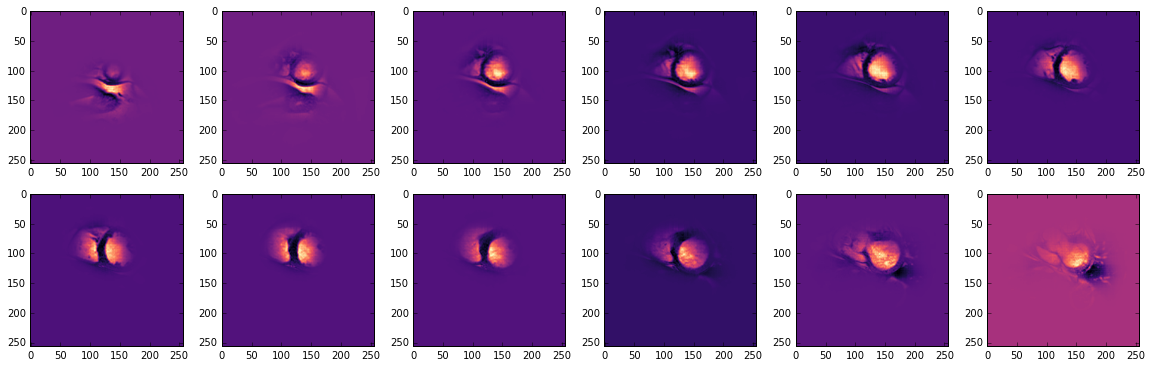

In [71]:
plt.figure(figsize=(20,6))    
for s in range(12):
    plt.subplot(2, 6, s+1)
    plt.imshow((data_ED_train[s*2][4] * data_ED_train[s*2+1][4])[0,:,:], cmap=plt.cm.magma)

### Maximum intensity projections

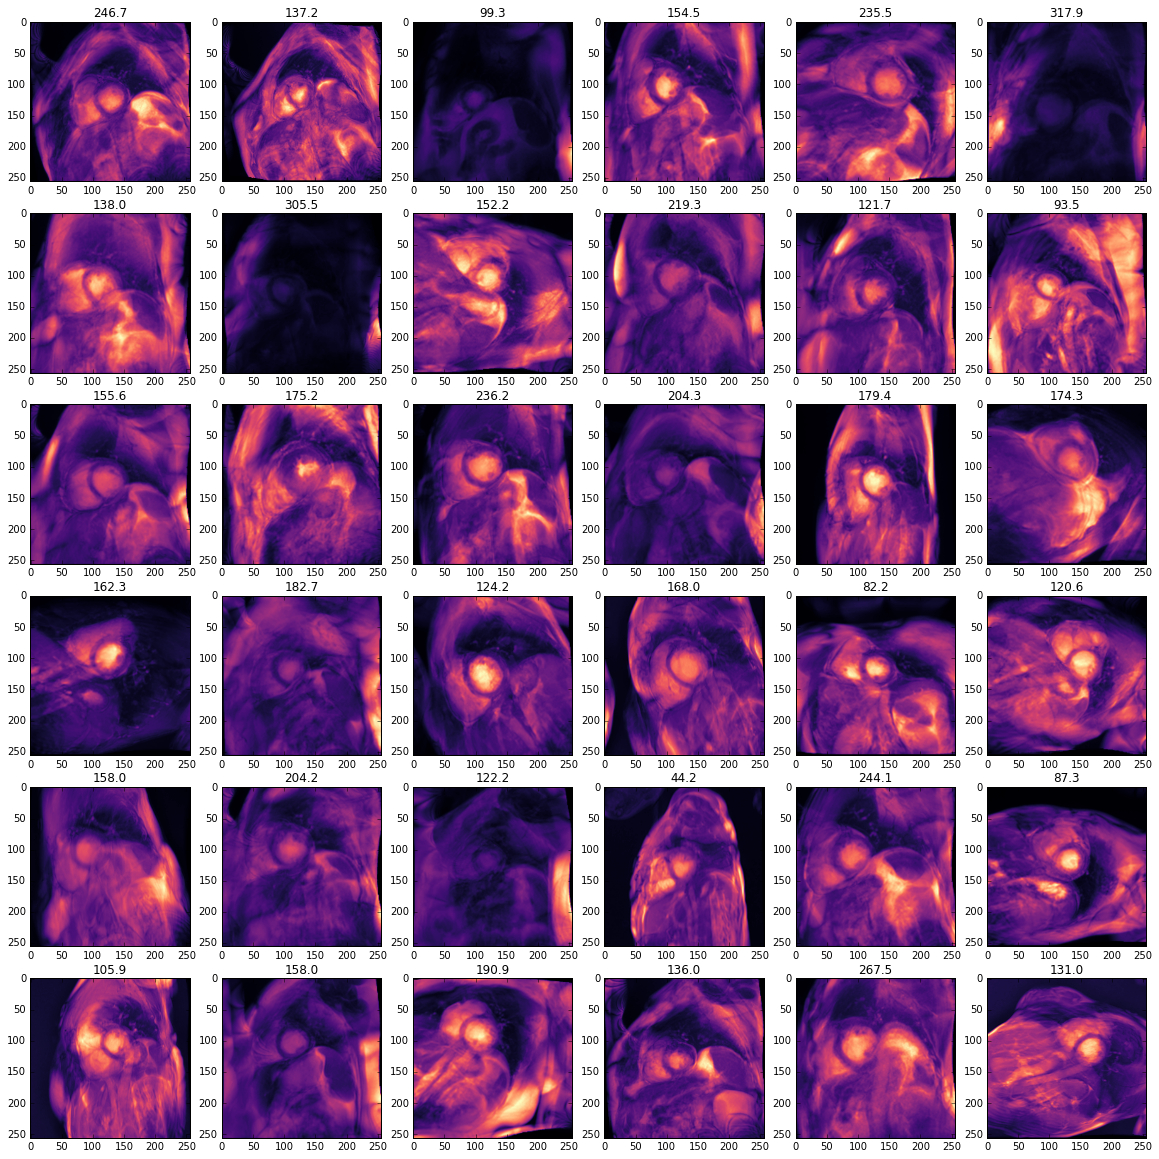

In [95]:
plt.figure(figsize=(20,20))    
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.title(labels_value_ED_train[i])
    plt.imshow(np.sum((data_ED_train[s*2][i]) for s in range(12))[0,:,:], cmap=plt.cm.magma)

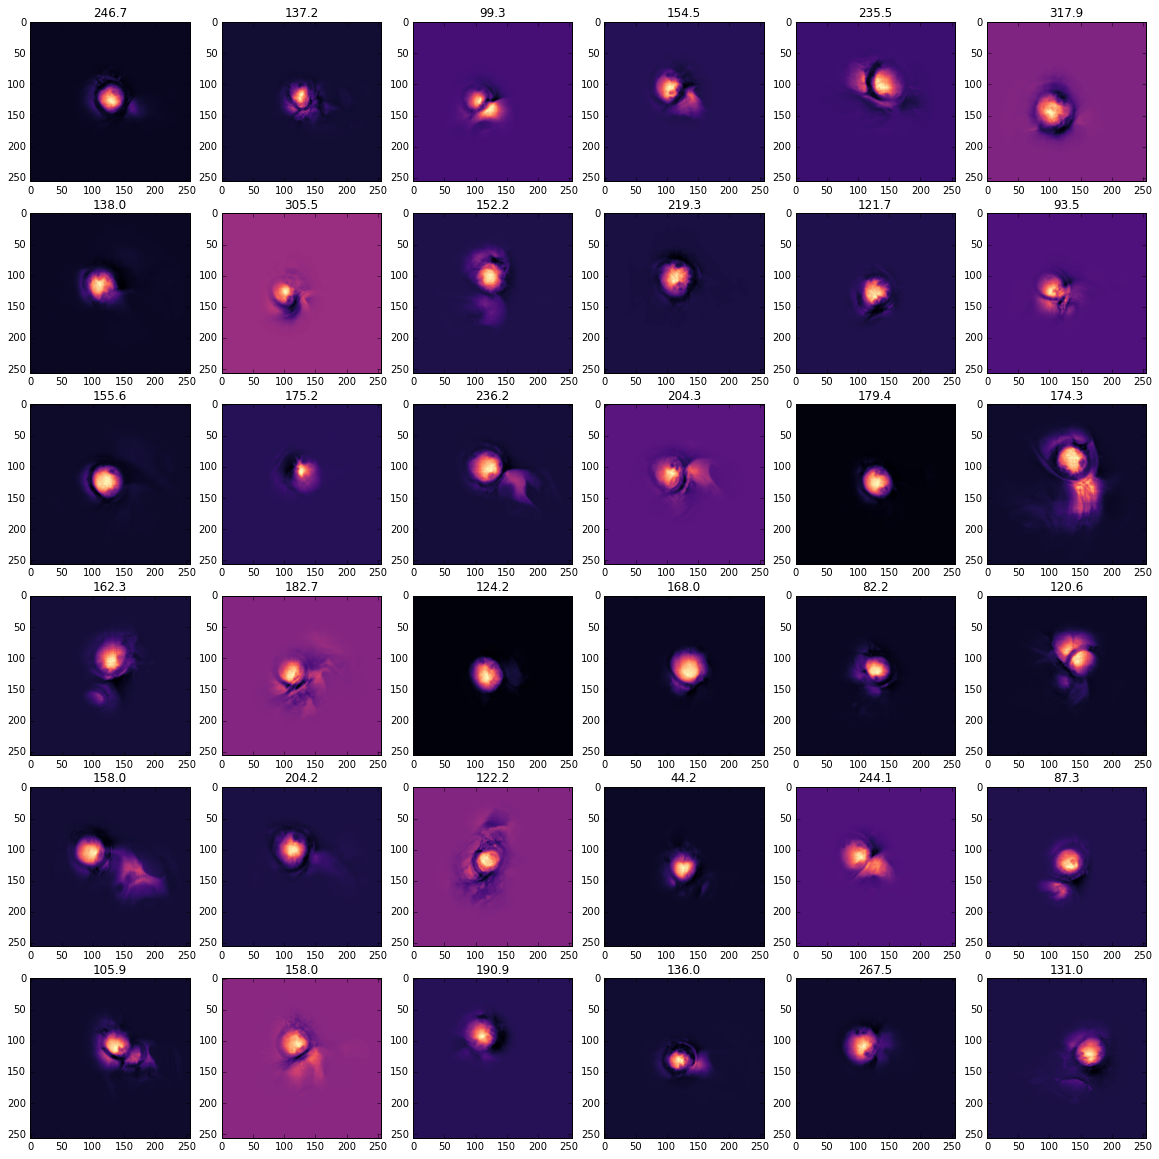

In [97]:
plt.figure(figsize=(20,20))    
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.title(labels_value_ED_train[i])
    plt.imshow(np.sum((data_ED_train[s*2][i] * data_ED_train[s*2+1][i]) for s in range(12))[0,:,:], cmap=plt.cm.magma)

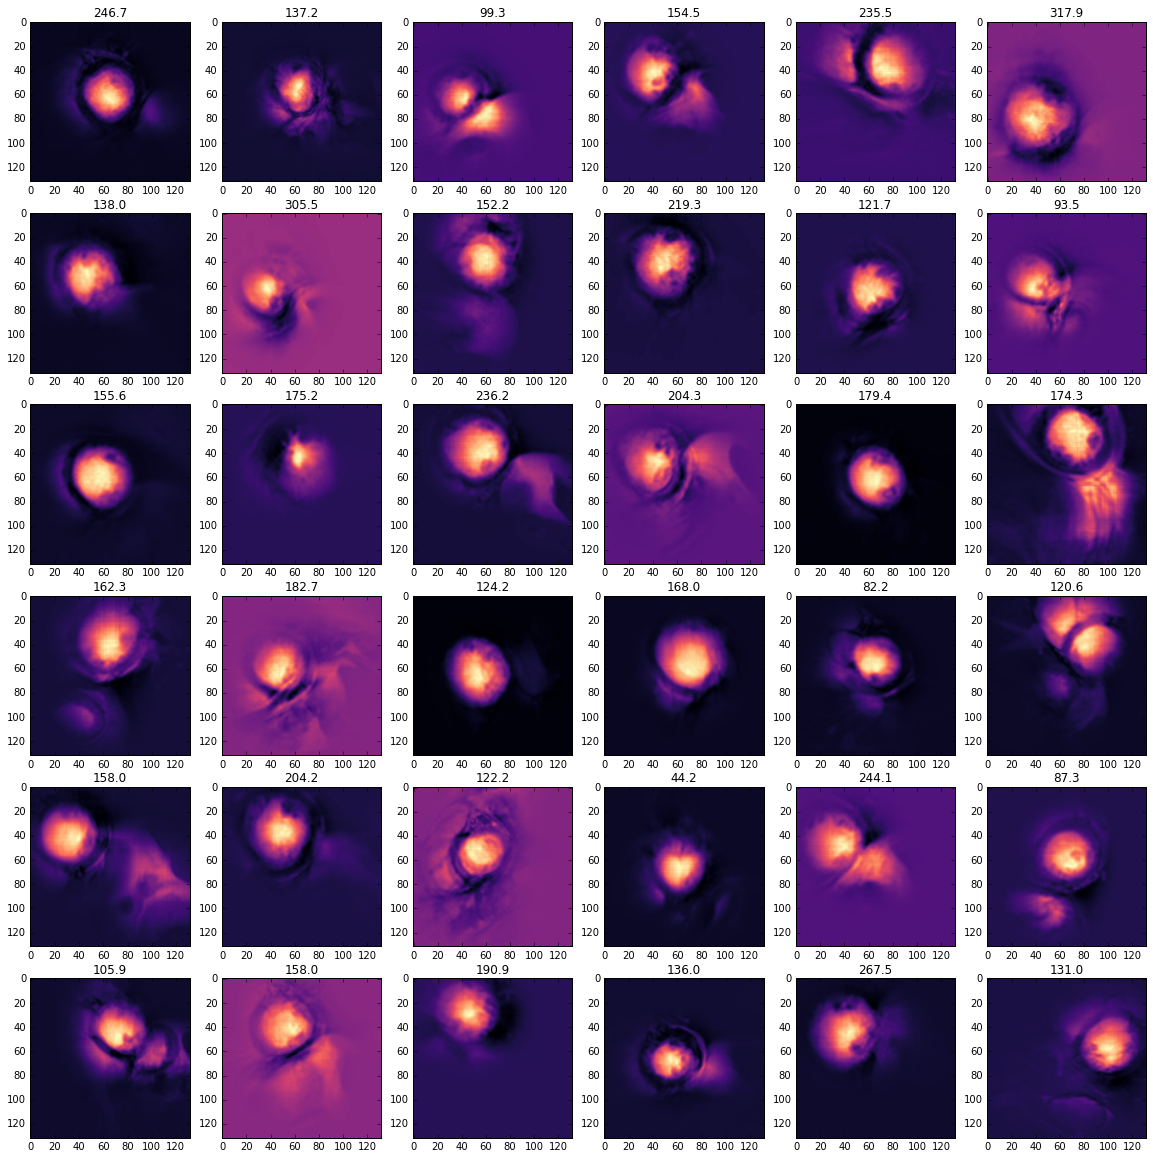

In [96]:
plt.figure(figsize=(20,20))    
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.title(labels_value_ED_train[i])
    plt.imshow(np.sum((data_ED_train[s*2][i] * data_ED_train[s*2+1][i]) for s in range(12))[0,64:196,64:196], cmap=plt.cm.magma)